In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [2]:
housing = pd.read_csv('https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv')

### Stratified split into train and test

In [3]:
housing['income_cat'] = pd.cut(housing['median_income'], bins=[0,1.5,3,4.5,6,np.inf], labels=[1,2,3,4,5])
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing['ocean_proximity'], housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

### Re-define housing as only train data

In [13]:
housing = strat_train_set.copy()

### EDA
Scatter plot
Correlation score
Scatter matrix

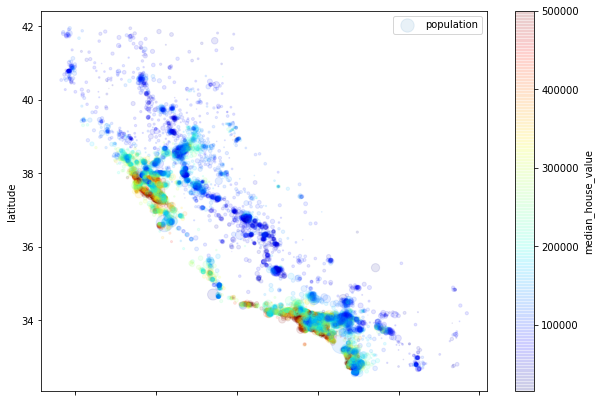

In [14]:
housing.plot(kind='scatter', x='longitude',y='latitude', alpha=0.1, 
             s=housing['population']/100, label='population', figsize=(10,7), 
             c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()
plt.show()

In [15]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.683395
total_rooms           0.135182
housing_median_age    0.104590
households            0.067550
total_bedrooms        0.052104
population           -0.024169
longitude            -0.040574
latitude             -0.150477
Name: median_house_value, dtype: float64

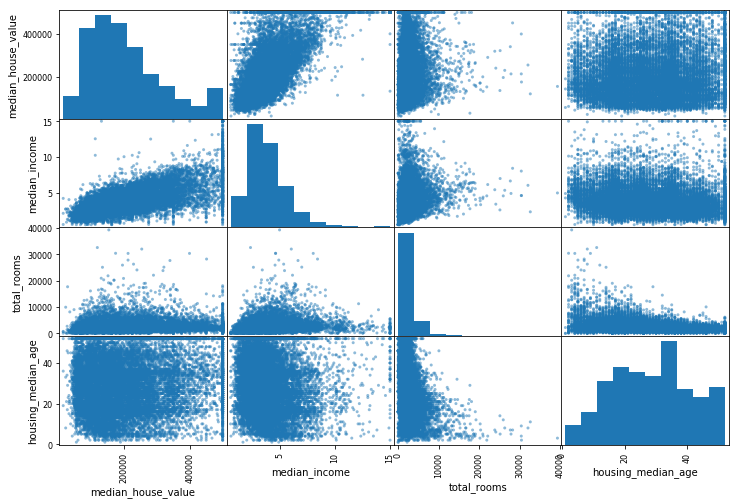

In [16]:
attributes = ['median_house_value','median_income','total_rooms','housing_median_age']
scatter_matrix(housing[attributes], figsize=(12,8))
plt.show()

### Prep for ML

In [17]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()
housing_num = housing.drop('ocean_proximity', axis=1)
housing_cat = housing[['ocean_proximity']]

### Defining pipelines for pre-processing data
##### Custom piping function for feature engineering

In [8]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

##### Pipe for numerical atributes
##### Full pipe for numerical and categorical attributes

In [18]:
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')), # Fix missing values
                        ('attribs_adder', CombinedAttributesAdder()),   # Feature enginnering
                        ('std_scaler', StandardScaler())])              # Scale numerical attributes

num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([('num', num_pipeline, num_attribs),
                                   ('cat', OneHotEncoder(), cat_attribs)])

housing_prepared = full_pipeline.fit_transform(housing)
pd.DataFrame(housing_prepared).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-0.109823,0.531578,1.136231,-0.108850,-0.247698,-0.482060,-0.310020,-0.164478,-0.004131,0.338222,-0.112601,-0.502162,0.0,1.0,0.0,0.0,0.0
1,0.619587,-0.772348,0.420106,-1.030194,-0.973136,-1.034853,-0.998738,-1.159597,-0.951550,-0.849209,-0.149134,1.794316,1.0,0.0,0.0,0.0,0.0
2,0.889369,-0.870493,-0.932575,0.706203,0.659706,0.907011,0.753636,0.484850,0.943287,-0.044664,0.017165,-0.296112,1.0,0.0,0.0,0.0,0.0
3,-0.874205,1.092406,-1.489562,-0.488527,-0.330189,-0.686700,-0.397772,-0.615173,-0.951550,-0.361819,-0.182418,0.602426,0.0,1.0,0.0,0.0,0.0
4,0.829417,-0.823757,0.260967,-0.433293,-0.631040,-0.619372,-0.621140,0.794368,0.943287,0.390219,-0.044835,-0.785977,1.0,0.0,0.0,0.0,0.0


### Evaluating three methods using cross validation

In [10]:
# Lin reg
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)
linreg_mse_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
linreg_rmse_scores = np.sqrt(-linreg_mse_scores)

# Tree
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)
tree_mse_scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-tree_mse_scores)

#Forest
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
forest_mse_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
forest_rmse_scores = np.sqrt(-forest_mse_scores)

def display_socres(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Sd:', scores.std())

print('Linreg')    
display_socres(linreg_rmse_scores)
print('Tree')  
display_socres(tree_rmse_scores)
print('Forest')  
display_socres(forest_rmse_scores)

c:\python\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Linreg
Scores: [69470.59817245 66795.1544655  69233.96549397 76588.12712429
 65565.75585795 65411.95366182 67309.38350999 69469.92002077
 69671.2779256  64973.61972311]
Mean: 68448.9755955445
Sd: 3226.3045596550196
Tree
Scores: [69868.63831081 75943.9748883  69798.7665067  68965.78047645
 67418.0056103  68216.32798969 70387.22765536 69864.84874164
 71391.57272909 74455.41614052]
Mean: 70631.05590488651
Sd: 2535.339866585256
Forest
Scores: [52300.74972316 53858.53178032 53068.15891831 51828.08339583
 52102.10111601 49512.7410917  50303.26648232 55195.60060357
 54730.1755606  52732.42185768]
Mean: 52563.18305294866
Sd: 1697.683945507477
